In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from skimage import io 
# from skimage.segmentation import mark_boundaries
# from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
# from skimage.filters import gabor, gaussian

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split,KFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, mean_squared_error, precision_recall_fscore_support, matthews_corrcoef

import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

import cv2

import tensorflow as tf
# import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical
from keras.optimizers import SGD
from keras.applications import ResNet50
from keras.applications.densenet import DenseNet201
from keras.applications.resnet50 import preprocess_input
from keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping




# import lime
# from lime import lime_image


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
from skimage.segmentation import mark_boundaries
from scipy.spatial.qhull import QhullError


<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [ ]:
os._exit(00)


## preprocessing

In [12]:
# Define the dataset directory
dataset_directory = '/kaggle/input/jmuben-coffee-dataset/JMuBEN/'

# Create a DataFrame to store file paths and labels
data = {'file_path': [], 'label': []}

# Iterate over directories and files to populate the DataFrame
for label in os.listdir(dataset_directory):
    class_dir = os.path.join(dataset_directory, label)
    if os.path.isdir(class_dir):
        for image_file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, image_file)
            data['file_path'].append(file_path)
            data['label'].append(label)

# Convert the data to a DataFrame
df = pd.DataFrame(data)

In [4]:
df.head()


NameError: name 'df' is not defined

In [13]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder to the labels and transform them to numeric values, and then add to the dataframe
df['numeric_label'] = label_encoder.fit_transform(df['label'])

#check value counts for each labels
print(df['numeric_label'].value_counts())

# check the label and it's encoder
print(df[['numeric_label', 'label']].drop_duplicates())
df.head()


numeric_label
1    18983
3    16978
2     8336
0     7681
4     6571
Name: count, dtype: int64
       numeric_label        label
0                  3        Miner
16978              2    Leaf rust
25314              0  Cerscospora
32995              4        Phoma
39566              1      Healthy


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


,file_path,label,numeric_label
0,/kaggle/input/jmuben-coffee-dataset/JMuBEN/Min...,Miner,3
1,/kaggle/input/jmuben-coffee-dataset/JMuBEN/Min...,Miner,3
2,/kaggle/input/jmuben-coffee-dataset/JMuBEN/Min...,Miner,3
3,/kaggle/input/jmuben-coffee-dataset/JMuBEN/Min...,Miner,3
4,/kaggle/input/jmuben-coffee-dataset/JMuBEN/Min...,Miner,3


the dataset is imbalanced, so it is best to undersample Miner and Healthy data on training set to the average number of the rest training set.

In [2]:
# Split the DataFrame into training and remaining data (40%)
train_df, remaining_df = train_test_split(
    df, 
    test_size=0.4, 
    random_state=42, 
    stratify=df['numeric_label'])

# Split the remaining data into validation and testing sets (each 20% of the original data)
validation_df, test_df = train_test_split(
    remaining_df, 
    test_size=0.5, 
    random_state=42, 
    stratify=remaining_df['numeric_label'])

# Calculate the average count of other classes for the training set
average_count = int(np.mean([train_df[train_df['numeric_label'] == label].shape[0] 
                             for label in np.unique(train_df['numeric_label']) 
                             if label not in [1, 3]]))

# Define the sampling strategy for RandomUnderSampler
sampling_strategy = {1: average_count, 3: average_count}

# Initialize RandomUnderSampler with the defined strategy
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)

# Apply RandomUnderSampler to the training data
X_resampled, y_resampled = rus.fit_resample(train_df[['file_path', 'numeric_label']], train_df['numeric_label'])

# Reconstruct the DataFrame from the resampled data
balanced_train_df = pd.DataFrame(X_resampled, columns=['file_path', 'numeric_label'])
balanced_train_df['label'] = y_resampled


NameError: name 'df' is not defined

In [19]:


# Function to load images from file paths
def load_images(file_paths):
    return [io.imread(path) for path in file_paths]

# Load training and validation images
X_train = load_images(balanced_train_df['file_path'].values)
y_train = balanced_train_df['numeric_label'].values

X_test = load_images(test_df['file_path'].values)
y_test = test_df['numeric_label'].values

X_val = load_images(validation_df['file_path'].values)
y_val = validation_df['numeric_label'].values

In [20]:
# Function to resize images in a list
def resize_images(image_list, target_size):
    resized_images = []
    for img in image_list:
        # Resize the image and append to the new list
        resized = cv2.resize(img, target_size)
        resized_images.append(resized)
    return resized_images

TARGET_SIZE = (128, 128)

# Resize the images in datasets
X_train = resize_images(X_train, TARGET_SIZE)
X_test = resize_images(X_test, TARGET_SIZE)
X_val = resize_images(X_test, TARGET_SIZE)



## Save files

In [21]:


# Directory where you want to save the arrays
save_directory = "/kaggle/working"

# List of tuples containing arrays and their respective filenames
arrays_and_filenames = [
    (X_train, "X_train.npy"),
    (X_test, "X_test.npy"),
    (y_train, "y_train.npy"),
    (y_test, "y_test.npy"),
    (y_val, "y_val.npy"),
    (X_val, "X_val.npy"),
]

# Ensure the save directory exists
os.makedirs(save_directory, exist_ok=True)

# Loop through each array and its filename, then save
for array, filename in arrays_and_filenames:
    # Save the array to a file
    save_path = os.path.join(save_directory, filename)
    np.save(save_path, array)

    print(f"Saved array to {save_path}")

Saved array to /kaggle/working/X_train.npy
Saved array to /kaggle/working/X_test.npy
Saved array to /kaggle/working/y_train.npy
Saved array to /kaggle/working/y_test.npy
Saved array to /kaggle/working/y_val.npy
Saved array to /kaggle/working/X_val.npy


## load files

In [14]:
# load saved arrays
'''
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
X_val = np.load("X_test.npy")
'''
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")
y_val = np.load("y_val.npy")

## hand craft

In [ ]:
# Custom function for grayscaling and Gaussian
def grayscale_images(image_array):
    return np.array([color.rgb2gray(img) for img in image_array])

# Select a few sample images 
# sample_images = X_train_handcrafted[:5]  
# apply gray-scale
# sample_images_gray = grayscale_images(sample_images)
images_gray = grayscale_images(X_train)
plt.imshow(images_gray[0],cmap='gray')  # cmap='gray' ensures true grayscale display
plt.axis('off')  # removes the axis for a cleaner image
plt.show()

In [ ]:
def GLCM_extractor(images):
    image_dataset = pd.DataFrame()
    for image in images:
        # Convert the image to uint8 if it's in floating-point format
        if image.dtype == 'float':
            image = img_as_ubyte(image)
            
        df = pd.DataFrame()
        
        # Configurations for the grey-level co-occurrence matrix calculation
        dists = [[1],[3],[5],[3],[3]]
        angles = [[0],[0],[0],[np.pi/4],[np.pi/2]]

        feature_data = {}
        for n, (dist, angle) in enumerate(zip(dists, angles)):
            GLCM = graycomatrix(image, distances=dist, angles=angle, levels=256, symmetric=True, normed=True)
            feature_data['Energy' + str(n)] = graycoprops(GLCM, 'energy')[0, 0]
            feature_data['Corr' + str(n)] = graycoprops(GLCM, 'correlation')[0, 0]
            feature_data['Diss_sim' + str(n)] = graycoprops(GLCM, 'dissimilarity')[0, 0]
            feature_data['Homogen' + str(n)] = graycoprops(GLCM, 'homogeneity')[0, 0]
            feature_data['Contrast' + str(n)] = graycoprops(GLCM, 'contrast')[0, 0]

        # Append the features of this image to the dataset
        image_dataset = pd.concat([image_dataset, pd.DataFrame([feature_data])], ignore_index=True)

    return image_dataset

# Apply the feature extraction to the grayscale images
GLCM_features = GLCM_extractor(images_gray)


In [ ]:
print(GLCM_features.shape)
GLCM_features.head()

In [ ]:

def extract_gabor_features(images, frequencies, thetas):
    gabor_features = []
    for image in images:
        image_features = []
        for frequency in frequencies:
            for theta in thetas:
                gabor_response = gabor(image, frequency=frequency, theta=theta)
                gabor_features_mean = np.mean(gabor_response[0])
                image_features.append(gabor_features_mean)
        gabor_features.append(image_features)
    return np.array(gabor_features)

# Example usage
frequencies = [0.1, 0.3, 0.5]  # Example frequencies
thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Example orientations
gabor_features = extract_gabor_features(images_gray, frequencies, thetas)


In [ ]:
gabor_features

I was wrong! the training

In [ ]:
def extract_lbp_features(images, P, R, method='uniform'):
    """
    Extract LBP features from a list of images.
    
    :param images: List of images (numpy arrays).
    :param P: Number of circularly symmetric neighbor set points.
    :param R: Radius of circle.
    :param method: Method to extract LBP features. 'uniform' is commonly used.
    :return: Numpy array of LBP features.
    """
    lbp_features = []
    for img in images:
        # Convert the image to unsigned byte format
        img = img_as_ubyte(img)
        lbp = local_binary_pattern(img, P, R, method)
        # Convert the LBP image to a histogram
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)  # Normalize the histogram
        lbp_features.append(hist)
    return np.array(lbp_features)

# P = 8, Number of circularly symmetric neighbor set points
# R = 1, Radius of circle
lbp_features = extract_lbp_features(images_gray, 8, 1)


In [ ]:
lbp_features.shape
np.save(os.path.join("/kaggle/working/lbp_features.npy"), lbp_features)

CNN method

In [ ]:
def extract_cnn_features(images):
    # Load pre-trained MobileNet V3 model
    base_model = Sequential([
        hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v3/frameworks/TensorFlow2/variations/large-075-224-feature-vector/versions/1",
                       trainable=False),  # Can be True, see below.
        Dense(1280, activation='softmax')
    ])
    base_model.build([None, 128, 128, 3])  # Batch input shape.

    # Fine-tuning - freeze the top 150 layers
    for layer in base_model.layers[:-150]:
        layer.trainable = False

    # Create a new model with the output layer of base_model
    model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

    # Normalize images
    images_normalized = images / 255.0  

    # Step 4: Feature extraction with fine-tuned MobileNet
    features = model.predict(images_normalized)

    # Flatten the features for PCA
    features_flattened = features.reshape(features.shape[0], -1)

    # Steps 5-7: PCA to reduce features to 10 components and append to feature vector
    pca = PCA(n_components=10)
    features_reduced = pca.fit_transform(features_flattened)

    return features_reduced

# Example usage
# images_processed should be your array of preprocessed images
cnn_features = extract_cnn_features(np.array(X_train))


In [6]:
X_train[0].shape

(128, 128, 3)

## Use first preprocessing method: 
use the histogram equalizer on the images to expand the grey-level distribution range from 0 to 255. The images will also be normalized in the range of [0,1]

In [7]:
def prep1(images):
    # Initialize an empty list to store the equalized images
    processed_img = []

    for img in images:
        # Ensure the image is in grayscale
        if len(img.shape) > 2:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply histogram equalization
        equ = cv2.equalizeHist(img)
        normalized_image = equ / 255.0

        # Append the equalized image to the list
        processed_img.append(normalized_image)

    return processed_img


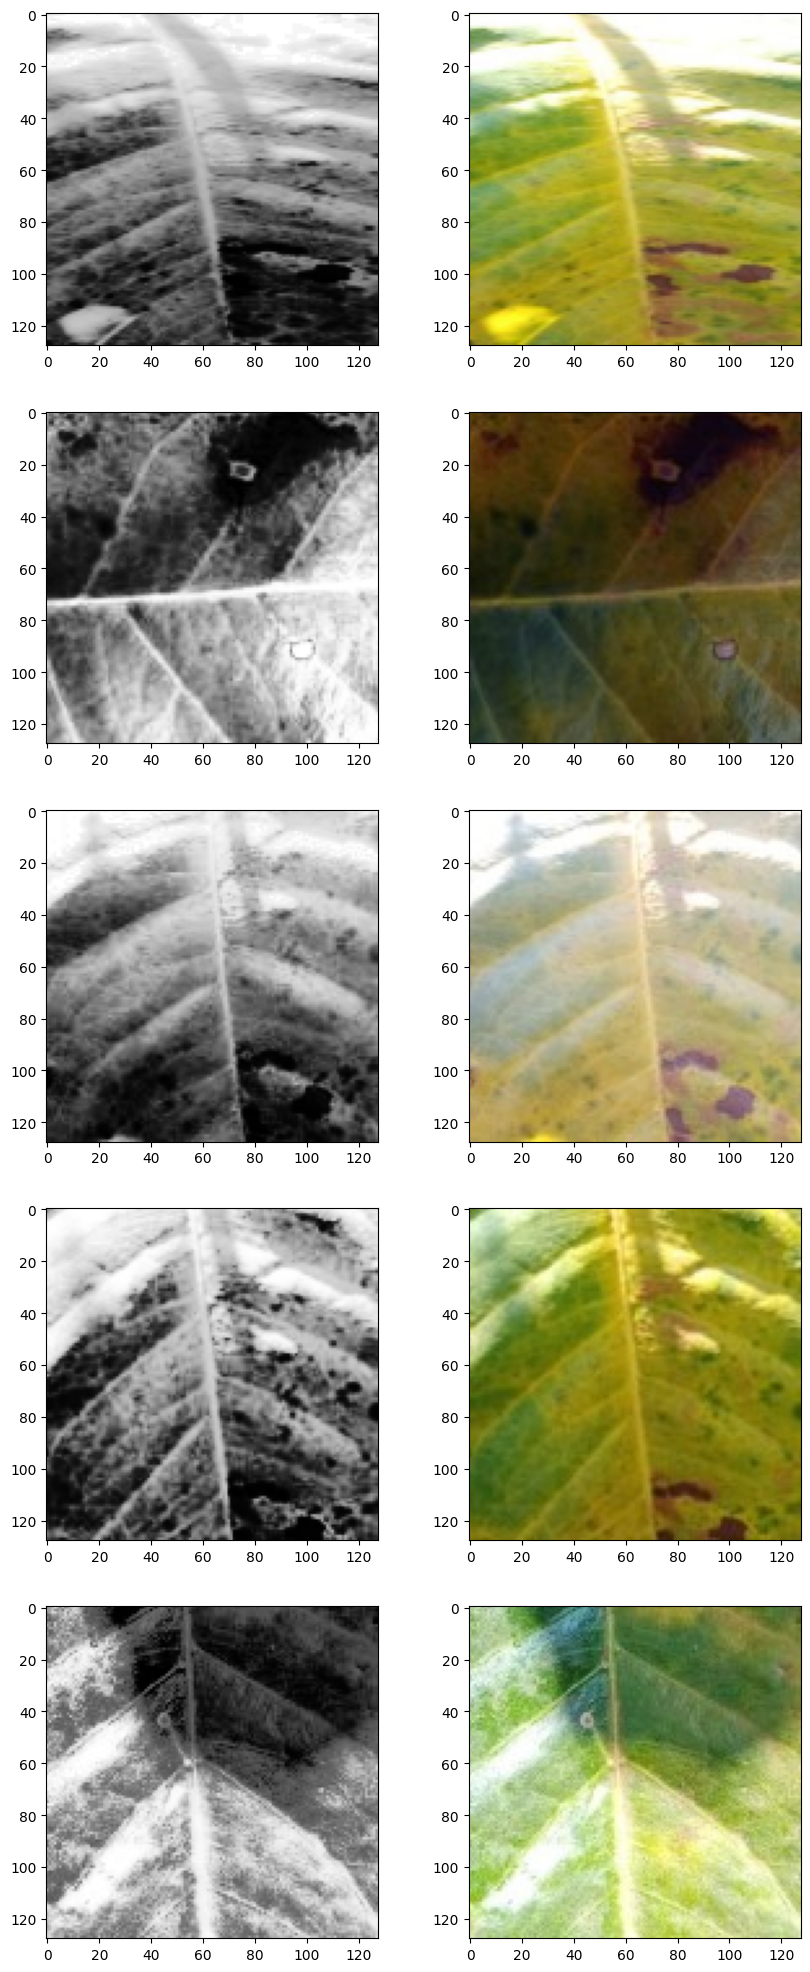

In [7]:
tryimg = prep1(X_train[:5])


n = len(tryimg)  # Number of images
fig, axs = plt.subplots(n, 2, figsize=(10, n*5))  # Create subplots

for i in range(n):
    axs[i, 0].imshow(tryimg[i], cmap='gray')  # Display each image from tryimg
    axs[i, 1].imshow(X_train[i], cmap='gray')  # Display each image from X_train

plt.show()  # Show all images




## a custom CNN 
that is less complex but very efficient, it is composed of two convolutional layers with a 5X5 size core and four convolutional layers with a 3X3 size core. For each pair of convolutional layers, there is a maxpooling that will allow for a reduction of the images and the whole will be connected to 128 fully connected layers.

In [8]:
# first, apply the prep1
X_train_prep1 = prep1(X_train)
X_test_prep1 = prep1(X_test)
X_val_prep1 = prep1(X_val)

In [15]:
# one-hot encode y arrays
num_classes = 5
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

In [11]:
X_train_prep1 = np.array(X_train_prep1)

X_val_prep1 = np.array(X_val_prep1)

X_test_prep1 = np.array(X_test_prep1)

print("X_train_prep1 shape:", X_train_prep1.shape)
print("y_train shape:", y_train.shape)
print("X_val_prep1 shape:", X_val_prep1.shape)
print("y_val shape:", y_val.shape)
print("X_test_prep1 shape:", X_test_prep1.shape)
print("y_test shape:", y_test.shape)


X_train_prep1 shape: (22586, 128, 128)
y_train shape: (22586, 5, 5)
X_val_prep1 shape: (11710, 128, 128)
y_val shape: (11710, 5, 5)
X_test_prep1 shape: (11710, 128, 128)
y_test shape: (11710, 5, 5)


In [16]:
y_train[0]

array([1., 0., 0., 0., 0.], dtype=float32)

## custom CNN without K fold

In [17]:
# Initialize the model
model = Sequential()

sgd_optimizer = SGD(lr=0.0001, momentum=0.9)

# Conv5-8: Convolutional layer with 5x5 kernels and 8 filters
model.add(Conv2D(8, (5, 5), activation='relu', padding='same', input_shape=(128, 128, 1)))

# Conv3-16: Convolutional layer with 3x3 kernels and 16 filters
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))

# Max-pool-2: Max pooling layer with a 2x2 window
model.add(MaxPooling2D(pool_size=(2, 2)))

# Batch normalization layer
model.add(BatchNormalization())

# Conv3-32: Convolutional layer with 3x3 kernels and 32 filters
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

# Conv3-64: Convolutional layer with 3x3 kernels and 64 filters
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

# Max-pool-2 and batch normalization
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# Conv3-128: Convolutional layer with 3x3 kernels and 128 filters
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

# Conv3-256: Convolutional layer with 3x3 kernels and 256 filters
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

# Max-pool-2 and batch normalization
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# Flatten the tensor output from the previous layer
model.add(Flatten())

# FC-128: Fully connected layer with 128 units
model.add(Dense(128, activation='relu'))

# FC-4 with softmax activation: Output layer with 4 units for classification
model.add(Dense(num_classes, activation='softmax'))  

# Compile the model
model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [18]:
# Define your batch size (you can start with 32 and reduce if you still encounter memory issues)
batch_size = 64
epochs=20
'''
# Train the model with the batch size
model.fit(X_train_prep1, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val_prep1, y_val))

# Evaluate the model with the batch size
score = model.evaluate(X_test_prep1, y_test, batch_size=batch_size)
##########

# Define the ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint(
    'best_model.h5',            # Path where to save the model
    save_best_only=True,        # Only save a model if `val_loss` has improved
    monitor='val_loss',         # Monitor 'val_loss' for improvements
    mode='min'                  # The lower the 'val_loss' the better
)
'''

# Train the model with the defined callbacks
history = model.fit(
    X_train_prep1, 
    y_train, 
    batch_size=batch_size, 
    epochs=20, 
    validation_split=0.2 
    # callbacks=[checkpoint]  # Add the callbacks to the training
)

# Load the best model after training

# best_model = load_model('best_model.h5')


Epoch 1/20
283/283 [==============================] - 22s 41ms/step - loss: 0.1180 - accuracy: 0.9715 - val_loss: 28.8548 - val_accuracy: 0.0578
Epoch 2/20
283/283 [==============================] - 10s 35ms/step - loss: 7.1935e-05 - accuracy: 1.0000 - val_loss: 18.8262 - val_accuracy: 0.1273
Epoch 3/20
283/283 [==============================] - 10s 35ms/step - loss: 3.5892e-05 - accuracy: 1.0000 - val_loss: 21.2445 - val_accuracy: 0.1273
Epoch 4/20
283/283 [==============================] - 10s 35ms/step - loss: 3.0347e-05 - accuracy: 1.0000 - val_loss: 21.7984 - val_accuracy: 0.1273
Epoch 5/20
283/283 [==============================] - 10s 35ms/step - loss: 2.8674e-05 - accuracy: 1.0000 - val_loss: 21.9259 - val_accuracy: 0.1273
Epoch 6/20
283/283 [==============================] - 10s 35ms/step - loss: 1.7502e-05 - accuracy: 1.0000 - val_loss: 21.9711 - val_accuracy: 0.1273
Epoch 7/20
283/283 [==============================] - 10s 35ms/step - loss: 1.5076e-05 - accuracy: 1.0000 - va

In [20]:

def plot_evaluation_metrics(history, X_t, y_t, model):
    # Generate Loss Curve
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Generate Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

    # Predict the values from the test dataset
    y_pred = model.predict(X_t)
    # Convert predictions classes to one hot vectors 
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_t, axis=1)

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


# Now call the evaluation metrics plotting function
# plot_evaluation_metrics(history, X_test_prep1, y_test, model)


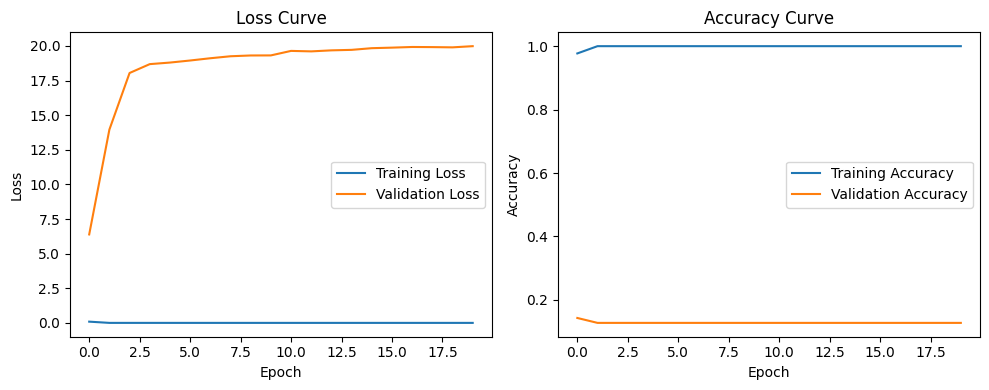

366/366 [==============================] - 3s 7ms/step


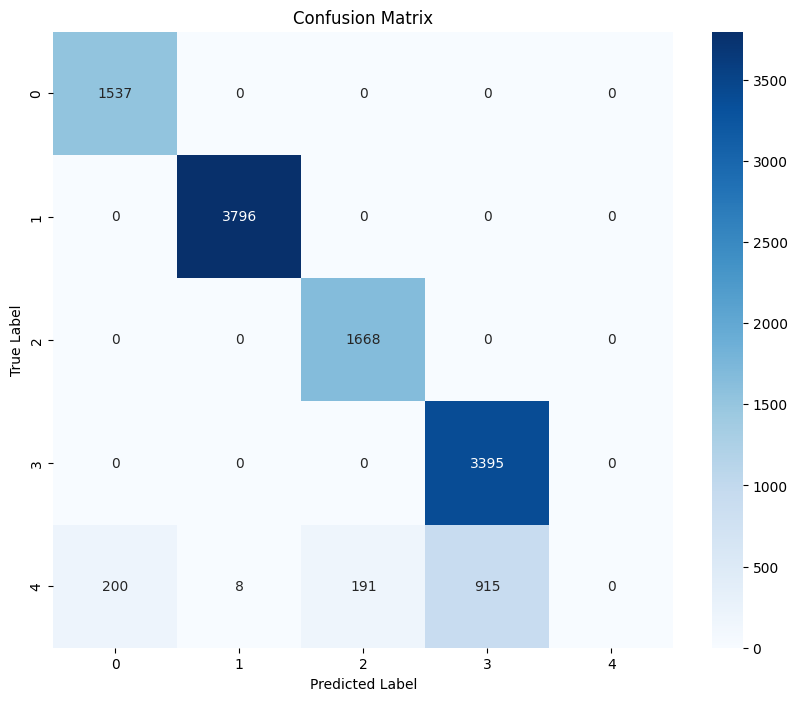

In [21]:
plot_evaluation_metrics(history, X_test_prep1, y_test, model)

In [19]:
def calculate_additional_metrics(y_true, y_pred):
    # For MSE, we need to convert the one-hot encoded vectors back to class integers
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_true_classes, y_pred_classes)

    # Calculate Precision, Recall, and F-score
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='weighted')

    # Calculate Matthews Correlation Coefficient
    mcc = matthews_corrcoef(y_true_classes, y_pred_classes)

    # Print the metrics
    print(f'Mean Squared Error: {mse}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F-score: {fscore}')
    print(f'Matthews Correlation Coefficient: {mcc}')
    
    return mse, precision, recall, fscore, mcc

# Usage example:
# y_pred = model.predict(X_test_prep1)
# mse, precision, recall, fscore, mcc = calculate_additional_metrics(y_test, y_pred)


In [20]:
y_pred = model.predict(X_test_prep1)
mse, precision, recall, fscore, mcc = calculate_additional_metrics(y_test, y_pred)

366/366 [==============================] - 3s 7ms/step
Mean Squared Error: 0.4901793339026473
Precision: 0.7954462518902972
Recall: 0.8877882152006832
F-score: 0.8371654896990749
Matthews Correlation Coefficient: 0.8610061980998827


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## custom CNN with K-fold

In [8]:
# Define the model architecture
def create_model():
    # Initialize the model
    model = Sequential()

    sgd_optimizer = SGD(lr=0.0001, momentum=0.9)

    # Conv5-8: Convolutional layer with 5x5 kernels and 8 filters
    model.add(Conv2D(8, (5, 5), activation='relu', padding='same', input_shape=(128, 128, 1)))

    # Conv3-16: Convolutional layer with 3x3 kernels and 16 filters
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))

    # Max-pool-2: Max pooling layer with a 2x2 window
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Batch normalization layer
    model.add(BatchNormalization())

    # Conv3-32: Convolutional layer with 3x3 kernels and 32 filters
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

    # Conv3-64: Convolutional layer with 3x3 kernels and 64 filters
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

    # Max-pool-2 and batch normalization
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Conv3-128: Convolutional layer with 3x3 kernels and 128 filters
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

    # Conv3-256: Convolutional layer with 3x3 kernels and 256 filters
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

    # Max-pool-2 and batch normalization
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Flatten the tensor output from the previous layer
    model.add(Flatten())

    # FC-128: Fully connected layer with 128 units
    model.add(Dense(128, activation='relu'))

    # FC-4 with softmax activation: Output layer with 4 units for classification
    model.add(Dense(num_classes, activation='softmax'))  

    # Compile the model
    model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Define the number of splits for K-fold
num_folds = 10

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Loop through each fold
for train, test in kfold.split(X_train_prep1, y_train):
    # Create and compile a new model (reinitializing weights)
    model = create_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Fit data to model
    history = model.fit(X_train_prep1[train], y_train[train],
                        batch_size=batch_size,
                        epochs=20,
                        verbose=1,
                        validation_data=(X_train_prep1[test], y_train[test]))

    # Generate generalization metrics
    scores = model.evaluate(X_train_prep1[test], y_train[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


Epoch 1/20
636/636 [==============================] - 17s 20ms/step - loss: 0.3504 - accuracy: 0.9205 - val_loss: 0.1295 - val_accuracy: 0.9646
Epoch 2/20
636/636 [==============================] - 12s 18ms/step - loss: 0.0671 - accuracy: 0.9846 - val_loss: 0.1606 - val_accuracy: 0.9672
Epoch 3/20
636/636 [==============================] - 12s 18ms/step - loss: 0.0271 - accuracy: 0.9934 - val_loss: 0.0175 - val_accuracy: 0.9934
Epoch 4/20
636/636 [==============================] - 12s 18ms/step - loss: 0.0807 - accuracy: 0.9874 - val_loss: 0.1246 - val_accuracy: 0.9739
Epoch 5/20
636/636 [==============================] - 12s 18ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.0090 - val_accuracy: 0.9991
Epoch 6/20
636/636 [==============================] - 12s 18ms/step - loss: 2.1976e-05 - accuracy: 1.0000 - val_loss: 0.0085 - val_accuracy: 0.9991
Epoch 7/20
636/636 [==============================] - 12s 18ms/step - loss: 0.1249 - accuracy: 0.9845 - val_loss: 0.4875 - val_accur

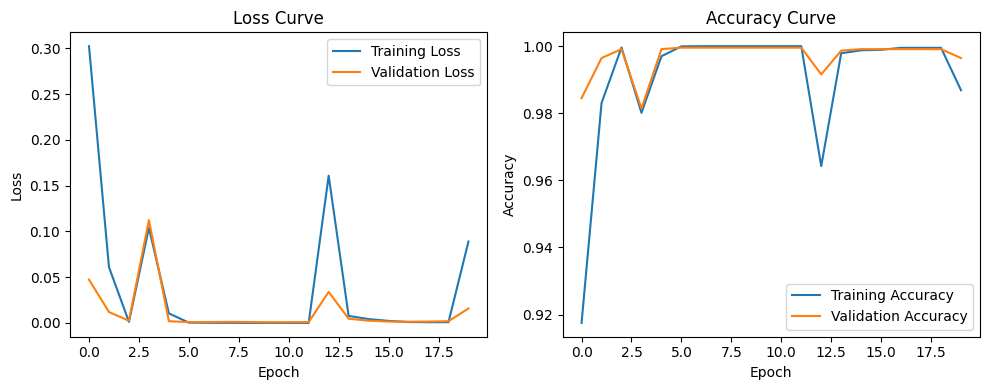

366/366 [==============================] - 2s 5ms/step


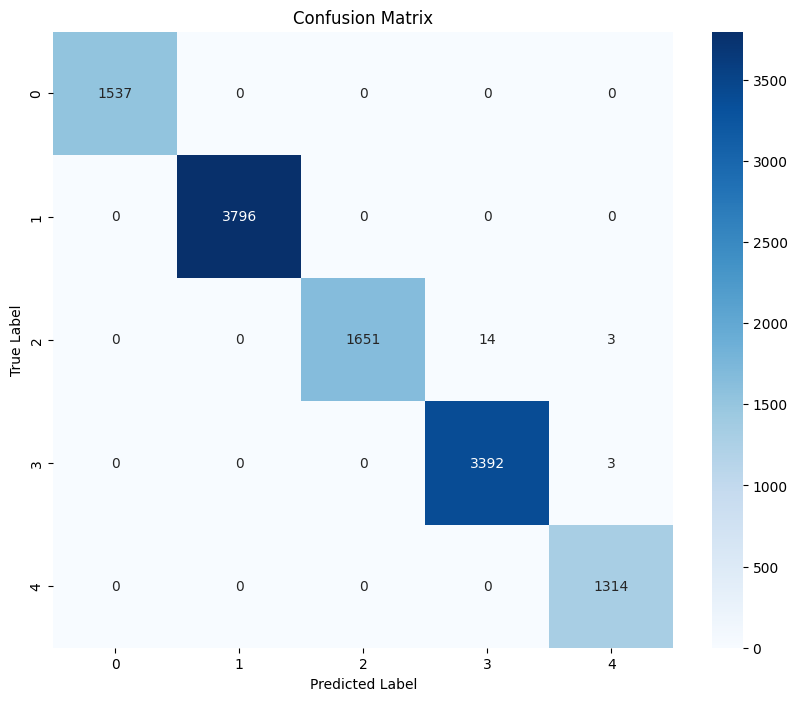

366/366 [==============================] - 2s 5ms/step
Mean Squared Error: 0.002476515798462852
Precision: 0.9982982482540503
Recall: 0.9982920580700256
F-score: 0.998290097735373
Matthews Correlation Coefficient: 0.9977567093797232


In [11]:
# Now call the evaluation metrics plotting function
plot_evaluation_metrics(history, X_test_prep1, y_test, model)
# Print the metrics
y_pred = model.predict(X_test_prep1)
mse, precision, recall, fscore, mcc = calculate_additional_metrics(y_test, y_pred)

## GradCam

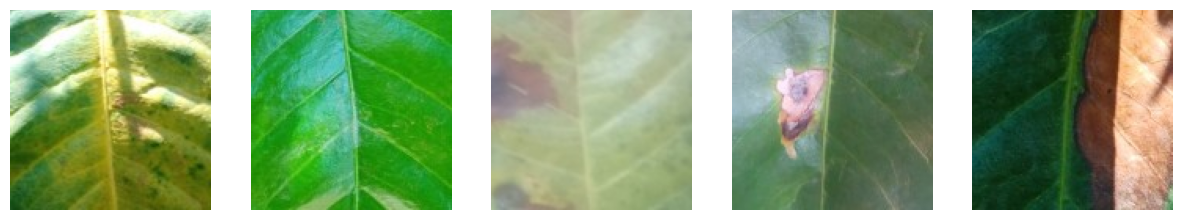

In [9]:
# randomly select the image of each class in X_train
class_indices = [np.where(np.argmax(y_train, axis=1) == i)[0] for i in range(5)]

# Create a random seed
rng = np.random.default_rng(seed=42)

# Randomly select one index from each class
selected_indices = [rng.choice(indices) for indices in class_indices]

# Select the corresponding images from X_train
# selected_images_prep1 = X_train_prep1[selected_indices]
selected_images = [X_train[i] for i in selected_indices]


fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i, img in enumerate(selected_images):
    axs[i].imshow(img)
    axs[i].axis('off')

plt.show()


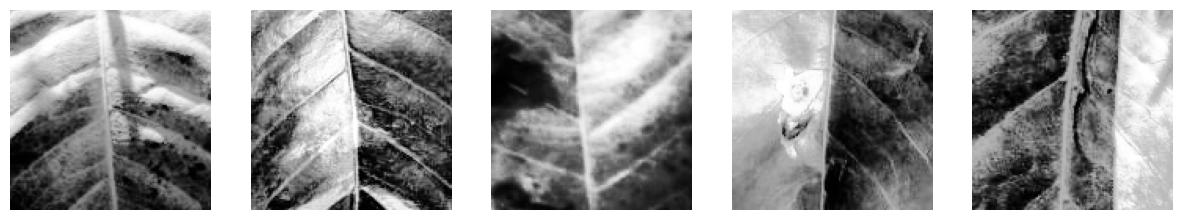

[411, 8103, 12398, 16108, 20350]

In [13]:
# selected image after preprocessing:
selected_images_prep1 = X_train_prep1[selected_indices]

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i, img in enumerate(selected_images_prep1):
    axs[i].imshow(img,cmap='gray')
    axs[i].axis('off')

plt.show()
selected_indices

In [20]:
selected_images_prep1.shape

(5, 128, 128, 1)

In [24]:

def grad_cam(model, image, cls, layer_name):
    """Generate a heatmap using Gradient-weighted Class Activation Mapping (Grad-CAM)"""
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    # Get the score for target class
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([image]))
        loss = predictions[:, cls]

    # Extract filters and gradients
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    # Compute the guided gradients
    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = gate_f * gate_r * grads

    # Average gradients spatially
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    # Build a heatmap from weights and activations
    cam = np.ones(output.shape[0:2], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    # ReLU and normalize heatmap
    cam = cv2.resize(cam.numpy(), (image.shape[1], image.shape[0]))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)

    # Apply heatmap to original image
    if len(image.shape) == 2 or image.shape[2] == 1:  # Grayscale image
        image = np.stack((image.squeeze(),)*3, axis=-1)  # Convert grayscale to RGB
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)  # Apply heatmap
    superimposed_img = heatmap * 0.4 + image  # Superimpose the heatmap on image
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)  # Clip to valid range

    return superimposed_img

# Usage example:
# img: your preprocessed input image as a numpy array
# model: your trained Keras model
# class_idx: the index of the class you want to visualize
# layer_name: the name of the last convolutional layer in your model

# grad_cam_img = grad_cam(model, img, class_idx, 'last_conv_layer_name')
# plt.imshow(grad_cam_img)


In [1]:
model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 128, 128, 8)       208       
                                                                 
 conv2d_67 (Conv2D)          (None, 128, 128, 16)      1168      
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 64, 64, 16)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_33 (Ba  (None, 64, 64, 16)        64        
 tchNormalization)                                               
                                                                 
 conv2d_68 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 conv2d_69 (Conv2D)          (None, 64, 64, 64)      

In [34]:
# Check the model's prediction
preds = model.predict(selected_images_prep1)
print("Predictions:", preds)
# Find the index of the maximum value in each prediction
print("Class indices:")
np.argmax(preds, axis=1)



1/1 [==============================] - 0s 19ms/step
Predictions: [[1.0000000e+00 1.8445174e-36 3.1908376e-20 1.2426495e-10 2.3736581e-17]
 [6.4007081e-14 9.9999714e-01 2.3671584e-10 2.6842804e-07 2.6655496e-06]
 [1.1528085e-01 4.2813007e-27 8.4347749e-01 3.8763054e-02 2.4785802e-03]
 [7.6620141e-27 1.3742344e-31 1.8056224e-19 9.9974769e-01 2.5224371e-04]
 [7.8149053e-25 0.0000000e+00 2.1384537e-36 1.1343455e-24 1.0000000e+00]]
Class indices:


array([0, 1, 2, 3, 4])

In [ ]:

heatmap = grad_cam(model, selected_images_prep1, cls=0, layer_name='conv2d_71')
plt.imshow(heatmap,cmap='gray')

## ResNet50

In [5]:

# Load the pre-trained ResNet50 model without the top layer (fully connected layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add new layers for this dataset
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [8]:
# Make sure X is a float32 array of shape (num_samples, 128, 128, 3)
X_train_normalized = X_train.astype('float32') / 255.0
X_val_normalized = X_val.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0


In [9]:
print(X_train_normalized.shape)
print(y_train.shape)
X_train_normalized[0]

(22586, 128, 128, 3)
(22586, 5)


array([[[0.41568628, 0.41568628, 0.21960784],
        [0.4862745 , 0.4862745 , 0.2901961 ],
        [0.4627451 , 0.47058824, 0.28627452],
        ...,
        [0.2784314 , 0.24313726, 0.09019608],
        [0.29803923, 0.2627451 , 0.10196079],
        [0.30980393, 0.27450982, 0.11372549]],

       [[0.4117647 , 0.40784314, 0.21960784],
        [0.4745098 , 0.47058824, 0.28235295],
        [0.47058824, 0.47843137, 0.29411766],
        ...,
        [0.28235295, 0.24705882, 0.09411765],
        [0.30588236, 0.27058825, 0.11764706],
        [0.32156864, 0.28627452, 0.1254902 ]],

       [[0.4117647 , 0.40784314, 0.22745098],
        [0.4509804 , 0.44705883, 0.27450982],
        [0.45882353, 0.4627451 , 0.2901961 ],
        ...,
        [0.29411766, 0.24313726, 0.10588235],
        [0.30980393, 0.25882354, 0.12156863],
        [0.32941177, 0.28235295, 0.13333334]],

       ...,

       [[0.45490196, 0.43529412, 0.34901962],
        [0.47843137, 0.4509804 , 0.3764706 ],
        [0.5058824 , 0

In [10]:
epochs = 20  
batch_size = 64  

# Train the model
history = model.fit(
    X_train_normalized, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2 
)

Epoch 1/20
283/283 [==============================] - 89s 159ms/step - loss: 0.0765 - accuracy: 0.9823 - val_loss: 8.8850 - val_accuracy: 0.0000e+00
Epoch 2/20
283/283 [==============================] - 40s 142ms/step - loss: 0.0198 - accuracy: 0.9952 - val_loss: 8.5143 - val_accuracy: 0.0000e+00
Epoch 3/20
283/283 [==============================] - 40s 142ms/step - loss: 0.0138 - accuracy: 0.9961 - val_loss: 6.7698 - val_accuracy: 0.0142
Epoch 4/20
283/283 [==============================] - 40s 142ms/step - loss: 0.0045 - accuracy: 0.9992 - val_loss: 1407.4340 - val_accuracy: 0.0033
Epoch 5/20
283/283 [==============================] - 40s 143ms/step - loss: 0.0340 - accuracy: 0.9920 - val_loss: 177.0005 - val_accuracy: 0.1270
Epoch 6/20
283/283 [==============================] - 40s 142ms/step - loss: 0.0194 - accuracy: 0.9952 - val_loss: 28.9852 - val_accuracy: 0.1273
Epoch 7/20
283/283 [==============================] - 40s 142ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 4

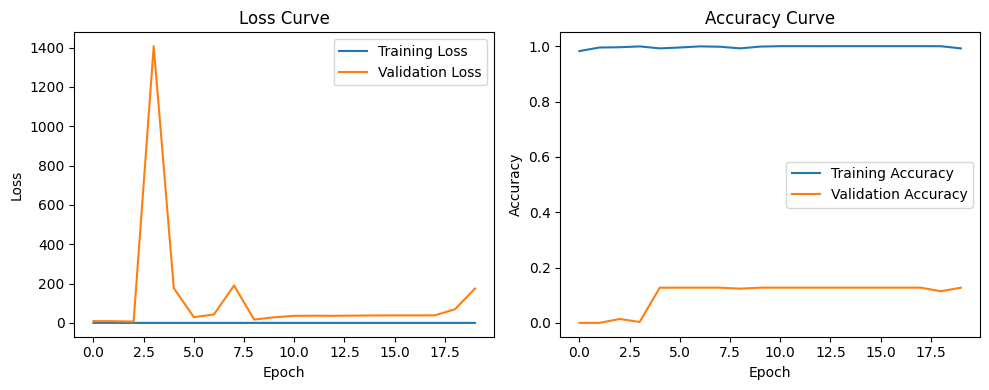

366/366 [==============================] - 11s 26ms/step


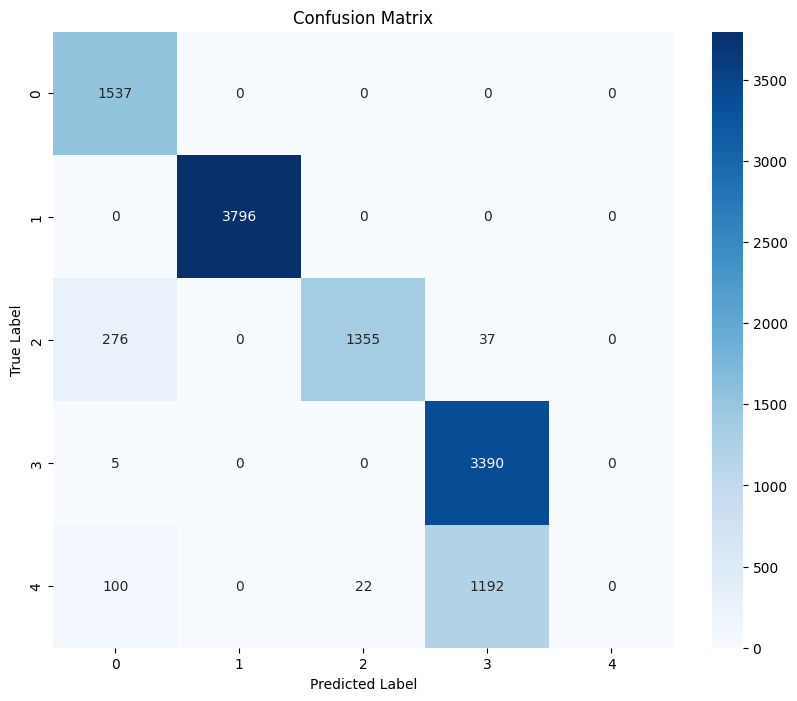

366/366 [==============================] - 9s 25ms/step


NameError: name 'calculate_additional_metrics' is not defined

In [14]:
# call the evaluation metrics plotting function
plot_evaluation_metrics(history, X_test_normalized, y_test, model)

In [12]:
def calculate_metrics(y_true, y_pred_probs, average_method='macro'):
    """
    Calculate performance metrics for classification.

    Parameters:
    y_true (array): True class labels (one-hot encoded if multi-class).
    y_pred_probs (array): Predicted probabilities for each class.
    average_method (str): Method to average multi-class metrics. Options: 'micro', 'macro', 'weighted', 'samples'.

    Returns:
    dict: A dictionary containing MSE, Precision, Recall, F1-Score, Support, and MCC.
    """
    # Convert predicted probabilities to class labels
    y_pred_labels = np.argmax(y_pred_probs, axis=1)

    # If y_true is one-hot encoded, convert it to class labels
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:
        y_true_labels = np.argmax(y_true, axis=1)
    else:
        y_true_labels = y_true

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_true, y_pred_probs)

    # Calculate Precision, Recall, F1-Score, and Support
    precision, recall, f1, support = precision_recall_fscore_support(y_true_labels, y_pred_labels, average=average_method)

    # Calculate Matthews Correlation Coefficient
    mcc = matthews_corrcoef(y_true_labels, y_pred_labels)

    return {
        'MSE': mse,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support,
        'MCC': mcc
    }


In [20]:
# Make predictions on the test set
y_pred_probs = model.predict(X_test_normalized)

# Calculate metrics
metrics = calculate_metrics(y_test, y_pred_probs, average_method='macro')

# Print the metrics
for metric, value in metrics.items():
    print(f"{metric}: {value}")


366/366 [==============================] - 9s 25ms/step
MSE: 0.05296063423156738
Precision: 0.7038607819328597
Recall: 0.7621754731708006
F1-Score: 0.7251456163505633
Support: None
MCC: 0.8270201998758102


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## VGG 16

In [16]:
# Load VGG16 model, include_top=False omits the fully-connected layers at the top of the network
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
# Flatten the output layer to 1 dimension
x = Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = Dropout(0.5)(x)

# Add a final softmax layer for classification
predictions = Dense(num_classes, activation='softmax')(x)

# The model we will train
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
epochs = 20  
batch_size = 64  

# Train the model
history = model.fit(
    X_train_normalized, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2 
)

Epoch 1/20
283/283 [==============================] - 64s 168ms/step - loss: 3399.4834 - accuracy: 0.5815 - val_loss: 560.5338 - val_accuracy: 0.0230
Epoch 2/20
283/283 [==============================] - 42s 150ms/step - loss: 54238940.0000 - accuracy: 0.2752 - val_loss: 14614.5889 - val_accuracy: 0.0000e+00
Epoch 3/20
283/283 [==============================] - 42s 150ms/step - loss: 38799204352.0000 - accuracy: 0.2729 - val_loss: 5.3435 - val_accuracy: 0.0000e+00
Epoch 4/20
283/283 [==============================] - 42s 150ms/step - loss: 207537553408.0000 - accuracy: 0.2728 - val_loss: 1148023341056.0000 - val_accuracy: 0.1273
Epoch 5/20
283/283 [==============================] - 42s 150ms/step - loss: 170573922304.0000 - accuracy: 0.2786 - val_loss: 981717745664.0000 - val_accuracy: 0.1273
Epoch 6/20
283/283 [==============================] - 42s 150ms/step - loss: 144596720.0000 - accuracy: 0.2708 - val_loss: 6.6064 - val_accuracy: 0.0000e+00
Epoch 7/20
283/283 [===================

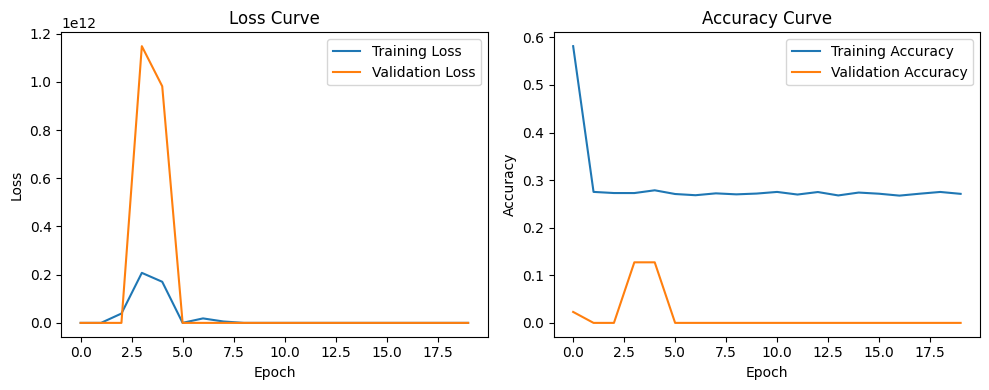

366/366 [==============================] - 11s 27ms/step


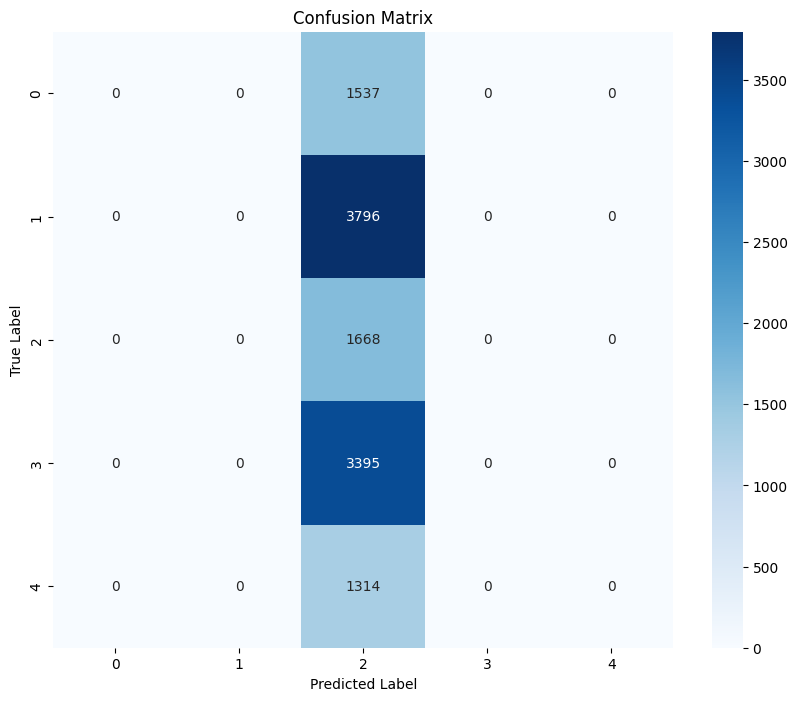

In [11]:
# call the evaluation metrics plotting function
plot_evaluation_metrics(history, X_test_normalized, y_test, model)

In [15]:
# Make predictions on the test set
y_pred_probs = model.predict(X_test_normalized)

# Calculate metrics
metrics = calculate_metrics(y_test, y_pred_probs, average_method='macro')

# Print the metrics
for metric, value in metrics.items():
    print(f"{metric}: {value}")


366/366 [==============================] - 9s 24ms/step
MSE: 0.1633569300174713
Precision: 0.028488471391972674
Recall: 0.2
F1-Score: 0.04987292569890866
Support: None
MCC: 0.0


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## DenseNet-201

In [6]:
# Load DenseNet201 model, include_top=False omits the fully-connected layer at the top of the network
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
# Create your own input format (here 128x128x3)
input_tensor = Input(shape=(128, 128, 3))

# Use the generated model 
x = base_model(input_tensor)

# Add GlobalAveragePooling2D layer to convert features into a single vector per image
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with ReLU activation
x = Dense(512, activation='relu')(x)

# Add a final softmax layer for classification
predictions = Dense(num_classes, activation='softmax')(x)

# The model we will train
model = Model(inputs=input_tensor, outputs=predictions)


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:
epochs = 20  
batch_size = 64  

# Train the model
history = model.fit(
    X_train_normalized, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2 
)

Epoch 1/20
283/283 [==============================] - 202s 291ms/step - loss: 0.0898 - accuracy: 0.9753 - val_loss: 1606.9614 - val_accuracy: 0.0000e+00
Epoch 2/20
283/283 [==============================] - 70s 246ms/step - loss: 0.0260 - accuracy: 0.9943 - val_loss: 109.9702 - val_accuracy: 0.1273
Epoch 3/20
283/283 [==============================] - 70s 246ms/step - loss: 7.2573e-04 - accuracy: 0.9998 - val_loss: 38.2995 - val_accuracy: 0.1273
Epoch 4/20
283/283 [==============================] - 70s 246ms/step - loss: 0.0244 - accuracy: 0.9934 - val_loss: 39.5392 - val_accuracy: 0.1273
Epoch 5/20
283/283 [==============================] - 70s 246ms/step - loss: 0.0062 - accuracy: 0.9987 - val_loss: 43.4891 - val_accuracy: 0.1273
Epoch 6/20
283/283 [==============================] - 70s 246ms/step - loss: 6.7773e-05 - accuracy: 1.0000 - val_loss: 43.5244 - val_accuracy: 0.1273
Epoch 7/20
283/283 [==============================] - 70s 246ms/step - loss: 0.0047 - accuracy: 0.9992 - val

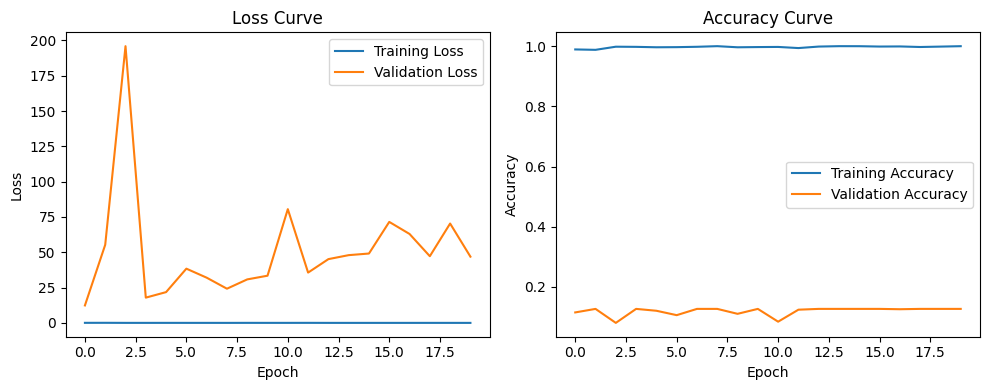

366/366 [==============================] - 24s 51ms/step


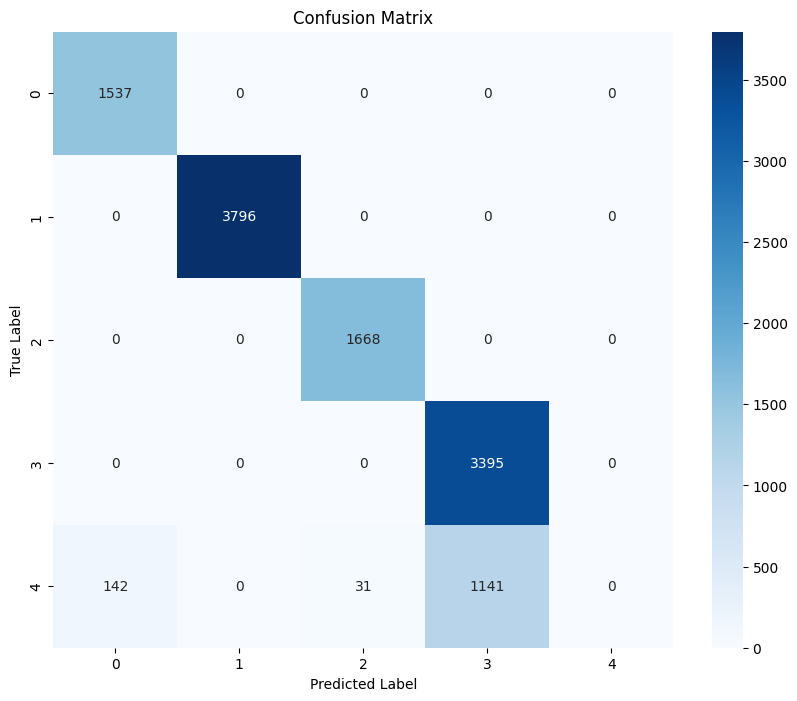

In [29]:
# call the evaluation metrics plotting function
plot_evaluation_metrics(history, X_test_normalized, y_test, model)

In [13]:
# Make predictions on the test set
y_pred_probs = model.predict(X_test_normalized)

# Calculate metrics
metrics = calculate_metrics(y_test, y_pred_probs, average_method='macro')

# Print the metrics
for metric, value in metrics.items():
    print(f"{metric}: {value}")


366/366 [==============================] - 16s 44ms/step
MSE: 0.04450717940926552
Precision: 0.733701578092196
Recall: 0.8
F1-Score: 0.762776794798097
Support: None
MCC: 0.8629955169241986


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
